# MINI-PROJECT 3    
## Background discrimination using the SoLid experiment SM1 module data
### QINTONG LI
### Date: 29/11/2021

---

# <a id="content"></a> CONTENT

# [Introduction](#intro)


# [Part I](#I)

## [Background Setup and Data Cleaning](#dc)
- [Present datasets in histograms](#hist)
- [Reveal correlation with scattered density plots](#correlation)

## [Hand-based analysis for simple cut](#sc)
- [$\Delta t$](#t)
- [$\Delta xy$](#xy)
- [$\Delta z$](#z)
- [$\Delta r$](#r)
- [Volume](#v)
- [$E_{prompt}$](#e)

# [Part II](#II)

## Machine learning approach
- [2D Classification](#2d)
- [3D Classification](#3d)
- [6D Classification](#6d)

## [Conclusion and Summary](#conclusion)

# <a id="intro"></a>[Introduction](#content)

This project is a typical classification problem in HEP where the experimental data contains large amount of background events and very few signal events (less than ~1% of total). 

The aim is to develop a simpler version of the analysis conducted with the first detector module SM1 to explore various multi-variate models. If you are interested, results from this analysis where published in article below to estimate the background expected for the first phase of the full scale experiment:

https://iopscience.iop.org/article/10.1088/1748-0221/13/05/P05005

The introductory material provided during the course should give you the necessary background to understand the dataset and the approach used to separate the signal and background. The paper is worth a read as it offers more in-depth description of the detector system and the measurements obtained

This exercise is done exclusively in Python and with the aim of introducing the basic classification tools and techniques that are use in most classification problems using some very prowerful library like ```scikit learn```

The project is split in two parts :

* The first part is to learn about the dataset, visualise the data and make sense of the metrics used to optimise the task. It focuses on developing a simple cut and count analysis based on 1 dimensional selection cut
* The second part is about developing the multi-variate analysis using machine learning algorithms like Support Vector Machines or Neural Nets to achieve superiro performance. 


## SoLid Datasets and format ##

The data sets used for the analysis are all saved in numpy arrays. They have been split in multiple datasets with specific running conditions and time selection that will be used to construct the different category of training samples needed for the analysis. More details can be found in the introductionary slides. 

### Antineutrino Monte Carlo simulation dataset
```IBD_sim_signal.npy```: This is the signal prediction dataset. Since it is not possible to use real antineutrino signal as it is the signal we want to extract, we use here the best prediction we have for it using a simulated sample (Geant4 Monte Carlo simulation). The predicted number of antineutrino interactions present in the reactor ON data is ~15 $\bar{\nu_e}$ . 

### SM1 detector datasets

There are two main periods for the data:
* Reactor **off** periods were only background signal is present (no antineutrinos).
* Reactor **on** periods were background **and** signal are present.

There is also two possible time window considered : 
* The **in-time coincidence window** that contains the correlated pair of signal events (Prompt and delayed).  
* The **shifted time coincidence window** where non-correlated backgrounds are present, also called **accidentals**

The combination of these time and data periods can be then split into:  

* Reactor On ```IBD_on_nonshifted.npy```: IBD candidates from the reactor **on** period, so reactor on background plus any signal.

* Reactor Off ```IBD_off_nonshifted.npy```: IBD candidates from the reactor **off** period, so reactor off background only.

* Reactor On Shifted ```IBD_on_shifted.npy```: IBD candidates from the reactor **on** period formed by using **shifted time** windows, therefore *accidental background for reactor on*. 

* Reactor Off Shifted ```IBD_off_shifted.npy```: IBD candidates from the reactor **off** period formed by using **shifted time** windows, therefore *accidental background for reactor off*. 


Each dataset are 2D numpy arrays and although this format is not very general (e.g. compared to having a class for each IBD candidate), it is very convenient for our purposes and numpy arrays computationally perform quickly. The dataset includes 6 variables of interests and each entry has the following structure [and unit]: 

```[delta_t (ns), delta_xy (cubes), delta_z (cubes), delta_r (cubes), volume (cubes), prompt_energy (MeV)]```

A first reduction of the dataset using pre-selection cuts was performed to make these datasets (basically reducing the background already by about a factor of ten to avoid manipulating too large samples). This includes: 
0 < delta_t (us) < 400 ;
prompt_energy > 1 MeV ;
0 <= delta_r <= 5. 

*NB: multiple shifted windows are used to increase the size of the sample, so the absolute rate does not corresponds to the rate expected in reactor on (non-shifted) sample. To scale back to the non-shifted, you will have to multiply the rate by a factor of 0.194.*

*NB: the reactor off runs are 12.2x longer in duration than reactor on.*


This pre-selection can be shown to be over 95% efficient, and for this exercise should be considered fully efficient (i.e. no loss of signal). 

All these datasets have the same format if loaded using the provided functions. Each dataset is a set of IBD candidates, stored as a 2D numpy array. 


## <a id="I"></a>[Part I](#content) 

### Learning about the dataset, classification task and simple cut analysis ##

- You can use the scripts provided (or write your own) to start looking at each variable and the differences for each datasets by looking at 1D histograms of the data and various binning size. You can for example also plot correlations between them. 
- What are the variables with the biggest difference between signal and background ? 
- Define some cut value for each variables and compute the $\frac{S}{\sqrt{S+B}}$ ratio which is the metric for the task. How are you going to define the cut values "by hand" ?  
- Once you have a set of selection cuts, Look at what true positive rate and false negative rate this corresponds to and optimise the metric as needed.

Here is an example of a short snippet to plot a specific variable based on the code provided:

# <a id="dc"></a>[Background Setup and Data Cleaning](#content)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# a bit of formating to make the plots looking professional
plt.rcParams['text.usetex'] = 0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
plt.rcParams.update({'figure.autolayout': True})

import data_getters # class to open the datasets
import mpl_examples #  class to plot

In the first step, datasets were imported as dataframes. `data_getters` is a useful tool to help importing data from IBD. In this process, all the variables were rename as: '$\Delta t$ [ns]', '$\Delta xy$ [cubes]', '$\Delta z$ [cubes]', '$\Delta r$ [cubes]', 'Volume [cubes]', '$E_{prompt}$[MeV]'. This is done for easier implementation at further stages.

In [2]:
# import data from IBD
dat1 = data_getters.get_data("IBD_off_nonshifted.npy")
dat2 = data_getters.get_data("IBD_on_nonshifted.npy")
dat3 = data_getters.get_data("IBD_off_shifted.npy")
dat4 = data_getters.get_data("IBD_on_shifted.npy")
simu = data_getters.get_data("IBD_sim_signal_nonshifted.npy")

# Transfrom datasets into Data Frames using pandas
df_offnonr = pd.DataFrame(dat1)
df_offnonr.columns = ['$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
                    '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]']
df_onnonr = pd.DataFrame(dat2)
df_onnonr.columns = ['$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
                    '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]']
df_offshiftr = pd.DataFrame(dat3)
df_offshiftr.columns = ['$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
                    '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]']
df_onshiftr = pd.DataFrame(dat4)
df_onshiftr.columns = ['$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
                    '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]']
df_simur = pd.DataFrame(simu)
df_simur.columns = ['$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
                    '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]']

# print out the data after dropping nan values
print('Number of available data in off_nonshifted IBD is {0}. \nNumber of available data in on_nonshifted IBD is {1}. \nNumber of available data in off_shifted IBD is {2}. \nNumber of available data in on_shifted IBD is {3}. \nNumber of available data in simulated signal IBD is {4}.'.format(len(df_offnonr.dropna()),len(df_onnonr.dropna()),len(df_offshiftr.dropna()),len(df_onshiftr.dropna()),len(df_simur.dropna())))

Number of available data in off_nonshifted IBD is 52605. 
Number of available data in on_nonshifted IBD is 10461. 
Number of available data in off_shifted IBD is 195964. 
Number of available data in on_shifted IBD is 45847. 
Number of available data in simulated signal IBD is 96762.


<div class="alert alert-info"> <p>
<b>Method</b>

A first reduction of the dataset using pre-selection cuts was performed to make these datasets (basically reducing the background already by about a factor of ten to avoid manipulating too large samples). 

    
This includes: 
- 0 < delta_t < 400000 ns;
- prompt_energy > 1 MeV ;
- 0 <= delta_r <= 5. 
    
</div>

In [3]:
# filter datasets with the range above
datsets = (df_offnonr,df_onnonr,df_offshiftr,df_onshiftr,df_simur)
#define a function to clean data
def Dataclean(k,names):
    """
    This function is defined to clean data and print out the lenth of cleaned datasets
    Input:
        k: name of raw datasets.
        names: name of each dataset in strings
    Output:
        lenth of each dataset
        cleaned dataset
    """
    #count = 0
    k1 = k.loc[k['$\Delta t$ [ns]']< 400000]
    k2 = k1.loc[k['$\Delta t$ [ns]'] > 0]
    k3 = k2.loc[k['$\Delta r$ [cubes]'] <= 5]
    k4 = k3.loc[k['$\Delta r$ [cubes]'] > 0]
    k = k4.loc[k['$E_{prompt}$[MeV]'] > 1]
    #count += 1
    print("The lenth of wanted number in {0} is {1}.".format(names,len(k)))
    return k

In [4]:
# rename all cleaned datasets
df_offnon = Dataclean(df_offnonr,'in off_nonshifted IBD')
df_onnon = Dataclean(df_onnonr,'on_nonshifted IBD')
df_offshift = Dataclean(df_offshiftr,'off_shifted IBD')
df_onshift = Dataclean(df_onshiftr,'on_shifted IBD')
df_simu = Dataclean(df_simur,'simulated signal IBD')

The lenth of wanted number in in off_nonshifted IBD is 24930.
The lenth of wanted number in on_nonshifted IBD is 4614.
The lenth of wanted number in off_shifted IBD is 83871.
The lenth of wanted number in on_shifted IBD is 19424.
The lenth of wanted number in simulated signal IBD is 79815.


# <a id="hist"></a>[Prensent Datasets In Histograms](#content)

- You can use the scripts provided (or write your own) to start looking at each variable and the differences for each datasets by looking at 1D histograms of the data and various binning size. You can for example also plot correlations between them. 

<div class="alert alert-info"> <p>
<b>Method</b>

After data cleaning, we can start looking at the data in the form of histgram. It should clearly show the relation between the signal we wanted and the background so that we can decided our method of classification.
    
</div>

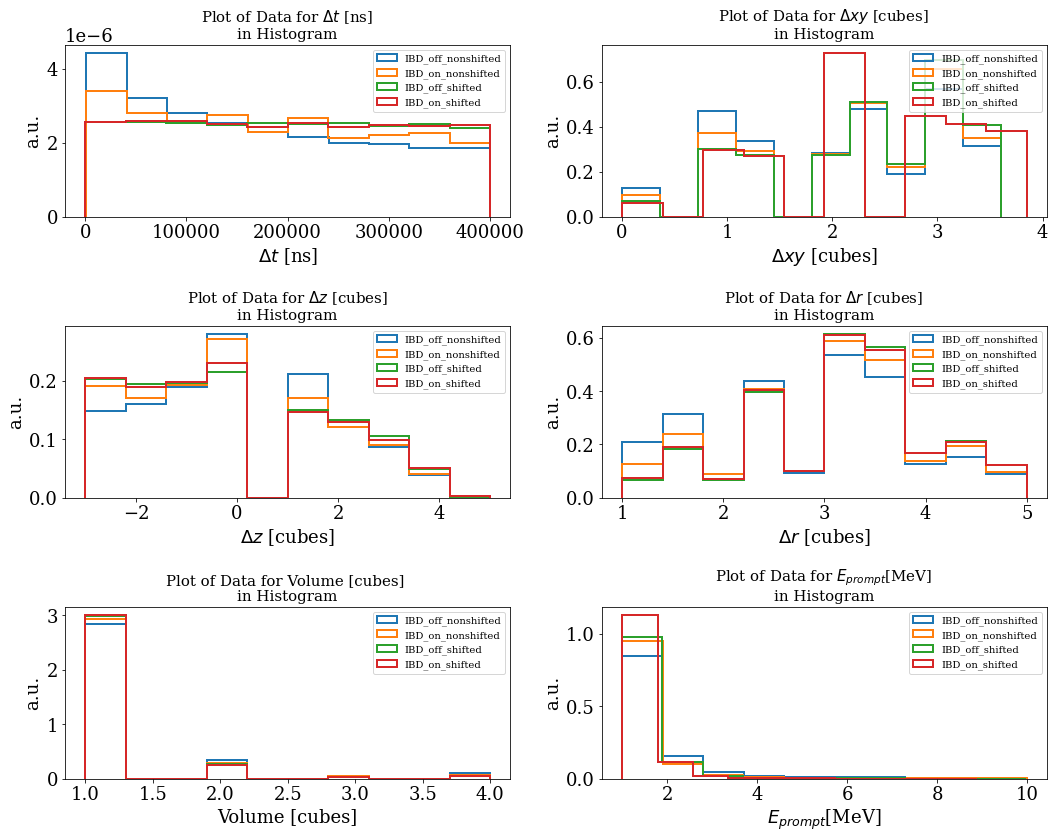

In [5]:
# print out all the data in the form of histogram for different variables
count = 0
labels = ('IBD_off_nonshifted','IBD_on_nonshifted','IBD_off_shifted','IBD_on_shifted')
for i in ('$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
          '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]'):
    plt.rcParams['figure.figsize'] = [15, 12]
    count += 1
    plt.subplot(3,2,count)
    plt.hist(df_offnon[i],  bins = 10, label = labels[0],
    cumulative = False, histtype='step', lw = 2, density=True)
    plt.hist(df_onnon[i],  bins = 10, label = labels[1],
    cumulative = False, histtype='step', lw = 2, density=True)
    plt.hist(df_offshift[i],  bins = 10, label = labels[2],
    cumulative = False, histtype='step', lw = 2, density=True)
    plt.hist(df_onshift[i],  bins = 10, label = labels[3],
    cumulative = False, histtype='step', lw = 2, density=True)
    plt.xlabel(i)
    plt.ylabel("a.u.")
    plt.legend(fontsize = 10)
    plt.title('Plot of Data for {0} \nin Histogram'.format(i),fontsize = 15)

<div class="alert alert-success"> <p>
<b>Discussion</b>

As it is clearly shown in the plots, even if the bin size was set as small as 10, some of the variables still present an obvious discrete feature. This means that some of the variables might not be useful in futher analysis. Therefore, looking for the correlations between variables can be helpful to determine the selection of predictors in classification/hand-based simple cut.
    
</div>

## <a id="correlation"></a> [Reveal correlation with scattered density plots](#content)

<div class="alert alert-info"> <p>
<b>Method</b>

**_Scattered Density Plots and Correlations_**
    
To study the correlation between varibles, scattered density plots could be significantly useful in many cases. If the variables tend to increase and decrease with specific pattern, there is correlation between them. If there is no pattern, the association is zero.
    
    
If the association is a linear relationship, a bivariate normal density ellipse summarizes the correlation between variables. The narrower the ellipse, the greater the correlation between the variables. The wider and roundier it is, the more the variables are uncorrelated.
    
    
In the following plots, blue points represents the background and red points represent the simulated signal from Monte Carlo simulation. Simulated signal was used here because the real signal has not been processed yet.
</div>

TODO


/home/ql1821/solid/lib64/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ql1821/solid/lib64/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


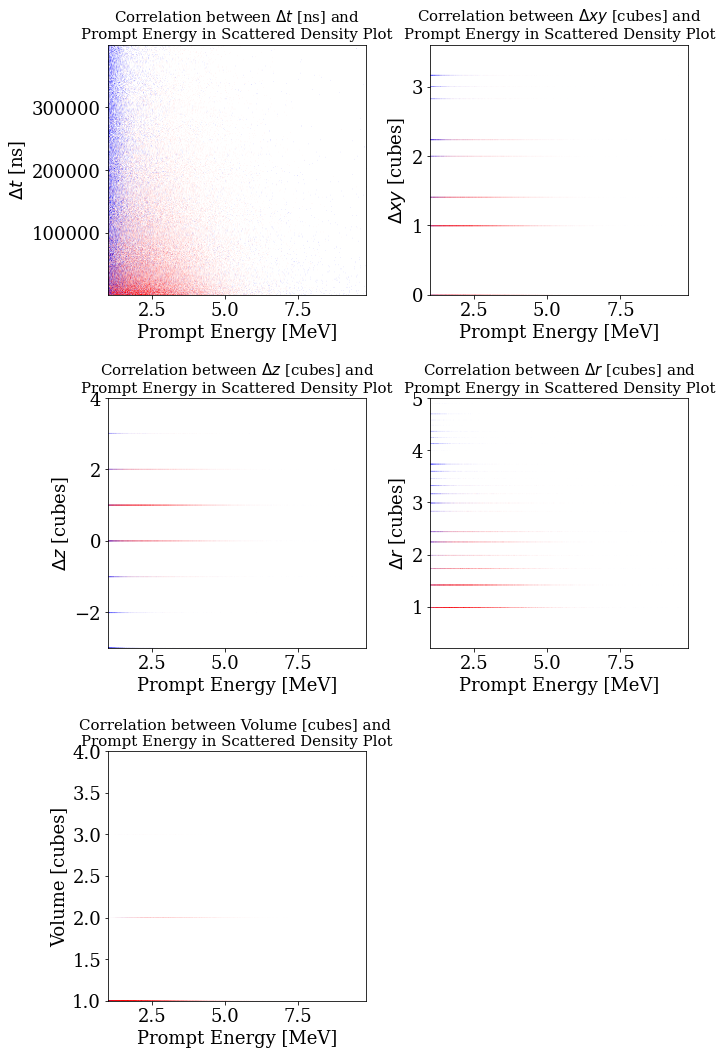

In [6]:
#!python
import IBD

plt.rcParams['figure.figsize'] = [10, 15]

# Make a density scatter plot to study correlations between variables
import mpl_scatter_density
fig = plt.figure()
count = 0
for m in ('$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
      '$\Delta r$ [cubes]','Volume [cubes]'):
    count += 1
    n = fig.add_subplot(3, 2, count, projection="scatter_density")
    n.scatter_density(df_offnon['$E_{prompt}$[MeV]'], df_offnon[m],color="blue")
    n.scatter_density(df_simu['$E_{prompt}$[MeV]'], df_simu[m],color="red")
    n.set_xlabel("Prompt Energy [MeV]")
    n.set_ylabel(m)
    plt.title('Correlation between {0} and \nPrompt Energy in Scattered Density Plot'.format(m),fontsize = 15)

<div class="alert alert-success"> <p>
<b>Discussion</b>

From the scattered density plots above, it can be illustrated that the non-correlation between $\Delta t$ and $E_{prompt}$ is the clearest one. Due to the discrete feature of the other variables, the pattern of correlation is not obvious enough. However, $\Delta xy$ and $\Delta z$ approximately show patterns of an ellipese while $\Delta r$ seem to be randomly scattered. Volume shows too little pattern to draw a conclusion.
    
Therefore, it can be initially concluded that $\Delta t$, $E_{prompt}$ and $\Delta r$ might be the most favourable varibales in futher analysis.
    
</div>

# Difference Between Signals and Background

- What are the variables with the biggest difference between signal and background ? 

### The neccessarity of scaling data due to shifting and reactor activation 

<div class="alert alert-info"> <p>
<b>Method</b>

*NB: multiple shifted windows are used to increase the size of the sample, so the absolute rate does not corresponds to the rate expected in reactor on (non-shifted) sample. To scale back to the non-shifted, you will have to multiply the rate by a factor of 0.194.*

*NB: the reactor off runs are 12.2x longer in duration than reactor on.*
    
$$R_{off} = 12.2 R_{on}$$
    
$$R_{non-shifted} = 0.194R_{shifted}$$

You could think about how to overlay a few plots and add error bars (statistical ones).
</div>

In [7]:
# define a function to plot histogram with associated errors
def Variable1D(k,s,xr,binn):
    """
    This function is used to scale 4 datasets as requested and plot their histograms on the same graph
    with x-axis being different varibles. It will also plot the error bars for each bin.
    Input:
        k: One of the variables('$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
        '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]')
        s: unit scaller
        xr: range for each variable
        binn: bin size
    Output:
        A Plot of Scaled $\Delta t$ [ns] in Four IBD Datasets \nwith Associated Errors
    """
    plt.rcParams['figure.figsize'] = [8, 5]
    # plot histograms and grab events number from it
    n1,bin1,patches1 = plt.hist(df_offnon[k]/s, binn, label = 'IBD_off_nonshifted',
    cumulative = False, histtype='step', lw = 2)
    n1 = n1
    n2,bin2,patches1 = plt.hist(df_onnon[k]/s, binn, label = 'IBD_on_nonshifted',
    cumulative = False, histtype='step', lw = 2)
    n2 = n2*12.2 # scale each dataset as required
    n3,bin3,patches1 = plt.hist(df_offshift[k]/s, binn, label = 'IBD_off_shifted',
    cumulative = False, histtype='step', lw = 2)
    n3 = n3*0.194
    n4,bin4,patches1 = plt.hist(df_onshift[k]/s, binn, label = 'IBD_on_shifted',
    cumulative = False, histtype='step', lw = 2)
    n4 = n4*12.2*0.194
    plt.legend()
    plt.close()# not showing the histogram before scaling

    # plot the scaled data set using stairs
    plt.stairs(n1,xr, label = 'IBD_off_nonshifted')
    plt.stairs(n2,xr, label = 'IBD_on_nonshifted')
    plt.stairs(n3,xr, label = 'IBD_off_shifted')
    plt.stairs(n4,xr, label = 'IBD_on_shifted')

    # calculating errorbars
    x1= 0.5 * (bin1[1:] + bin1[:-1])
    y_err1=n1**0.5
    plt.errorbar(x1,n1,y_err1,fmt=" k")

    x2= 0.5 * (bin2[1:] + bin2[:-1])
    y_err2=n2**0.5
    plt.errorbar(x2,n2,y_err2,fmt=" k")

    x3= 0.5 * (bin3[1:] + bin3[:-1])
    y_err3=n3**0.5
    plt.errorbar(x3,n3,y_err3,fmt=" k")

    x4= 0.5 * (bin4[1:] + bin4[:-1])
    y_err4=n4**0.5
    plt.errorbar(x4,n4,y_err4,fmt=" k")# plot error bars
    # complete details like axis labels a title
    plt.xlabel('{0}'.format(k))
    plt.ylabel('# Events')
    plt.legend(fontsize = 10)
    plt.title('A Plot of Scaled $\Delta t$ [ns] in Four IBD Datasets \nwith Associated Errors',fontsize = 15)

<div class="alert alert-info"> <p>
<b>Method</b>

The signal and background can be obatined as shown in the following eaquations:
$$R_{on}^{ACC} = R_{on}^{shifted}-R_{off}^{shifted}$$
    
$$R_{off}^{ACC} = R_{off}^{shifted}$$
    
$$R_{\bar{v_e}} = R_{on}-R_{off}-R_{on}^{ACC}$$
</div>

In [8]:
plt.rcParams['figure.figsize'] = [8, 5]

def SigBack(k,x,binn):
    """
    This function is used to plot the signals with background in off_nonshifted data
    on the same graph.
    Input:
        k: One of the variables('$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
        '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]')
        x: range of each variable
        binn: bin size
    Output:
        A Plot of $\Delta t$ [ns] for Antineutrinal Signal and Bakcground
    """
    # grab data from histogram and scale them
    n1,bin1,patches1 = plt.hist(df_offnon[k]/s, binn, label = 'IBD_off_nonshifted',
    cumulative = False, histtype='step', lw = 2)
    n1 = n1
    n2,bin2,patches1 = plt.hist(df_onnon[k]/s, binn, label = 'IBD_on_nonshifted',
    cumulative = False, histtype='step', lw = 2)
    n2 = n2*12.2
    n3,bin3,patches1 = plt.hist(df_offshift[k]/s, binn, label = 'IBD_off_shifted',
    cumulative = False, histtype='step', lw = 2)
    n3 = n3*0.194
    n4,bin4,patches1 = plt.hist(df_onshift[k]/s, binn, label = 'IBD_on_shifted',
    cumulative = False, histtype='step', lw = 2)
    n4 = n4*12.2*0.194
    plt.legend()
    plt.close()# # not showing the histogram before scaling
    
    # calculate the signal and background
    n_acc = n4-n3
    n_s = n2-n1-n_acc
    n_b = n2 - n_s
    plt.plot(x,n_s,label = 'Signal')
    plt.plot(x,n_b,label = 'Background')
    plt.xlabel('{0}'.format(k))
    plt.ylabel('# Counts')
    plt.legend()
    plt.title('A Plot of $\Delta t$ [ns] for Antineutrinal Signal and Bakcground',fontsize = 15)

$\Delta t$ is used as an example can be used to test the data.

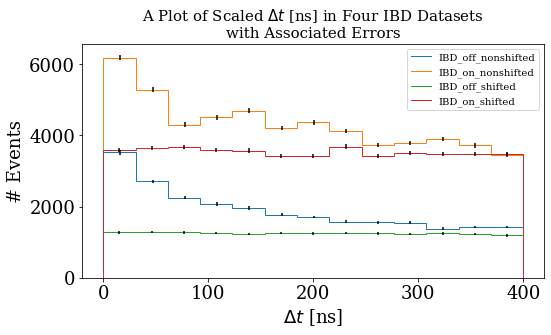

In [9]:
a = '$\Delta t$ [ns]'
s = 1000 # unit of ns change of microseconds
binn = 13
xr = np.linspace(0,400,14)
Variable1D(a,s,xr,binn)

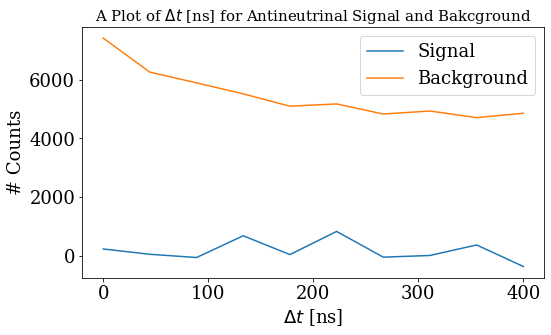

In [10]:
b = '$\Delta t$ [ns]'
xl = np.linspace(0.,400,10)
bin = 10
SigBack(b,xl,bin)

<div class="alert alert-success"> <p>

<b>Discussion: </b> 

The signal of $\Delta t$ at some point is negative and it does not agree with the theoretical prediction.It is challenging to carry out further research based on this result. Therefore, the signal obtained here might not meaningful for the following analysis. As this is very common in experiments, the data collected in the experiments may not be useful and new method for collecting data as well as the techniques we used to process them should be improved to solve this problem. 

To carry out this project to further stages, simulated signal from Monte Carlo simulation can be helpful to obtain a more sensible result.
    
</div>

# <a id="sc"></a>[Hand-based analysis for simple cut](#content)


<div class="alert alert-info"> <p>

<b>Method</b> 

Data in ```IBD_sim_signal.npy``` and```IBD_off_nonshifted.npy``` can be used as signal and background respectively. With these two sets of data, the simple hand-based cutting will be useful to do this 1D classification. The redult in this part will also be used as a good baseline for comparison with 2D or more dimentional classifications.
    
**_TPR and FPR_**
- The false positive rate is calculated as FP/FP+TN, where FP is the number of false positives and TN is the number of true negatives (FP+TN being the total number of negatives). It’s the probability that a false alarm will be raised: that a positive result will be given when the true value is negative.
- The true positive rate (TPR, also called sensitivity) is calculated as TP/TP+FN. TPR is the probability that an actual positive will test positive.
- An ROC curve can also be plot to help finding the optimal result. The performance of ROC is represented in the following illustration.
    
**_Metric ratio_**
- Define some cut value for each variables and compute the $\frac{S}{\sqrt{S+B}}$ ratio which is the metric for the task. The largest ratio corresponds to the x value for the best cuts.
    
</div>

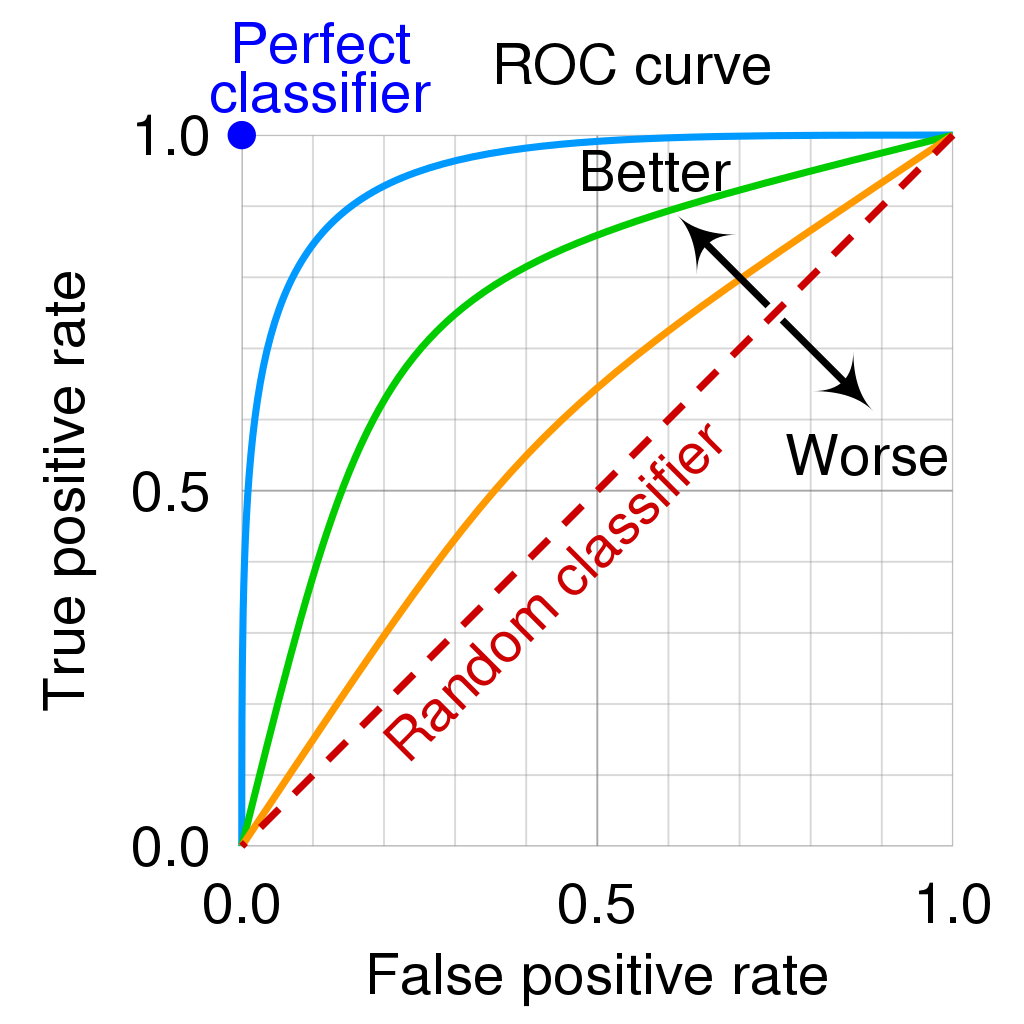

In [1]:
################################################
#### Define a function to plot the graphs ######
### for Hand-based Analysis simple cuts and ####
##### the corresponding evaluations  ###########
################################################

def HandBased(bins,a,ranges,xranges,y):
    """
    This function is used to do a handbased analysis on the signal and background. 
    It helps users to get a simple cut for each variable to classify signal and background.
    Input:
        bins: bin size.
        a: the index of each variable.
        ranges: ranges for different bin size
        xranegs: x axis ranges for each variables in metric ratio plot
        y: y axis ranges for each variables in metric ratio plot
    Output:
        A plot of Background and Simulated Signal for each variable \n with its Best Single cut.
        A plot of $\\frac{S}{\sqrt{S+B}}$ ratio curve.
        A plot of The ROC Curve for each variable.
    """
    plt.rcParams['figure.figsize'] = [10, 15]# set graph size
    # plot the Background and Simulated Signal for each variable and grab data from the histogram.
    plt.subplot(3,1,1)
    n_b,bin_b,patches_b = plt.hist(df_offnon[df_offnon.columns[a]], bins, label = 'Background',
    cumulative = False, histtype='step', lw = 2,density = True)
    n_ss,bin_ss,patches_ss = plt.hist(df_simu[df_offnon.columns[a]], bins, label = 'Signal',
    cumulative = False, histtype='step', lw = 2,density = True)
    plt.xlabel(df_offnon.columns[a])
    plt.ylabel('# of Counts')
    plt.title('Background and Simulated Signal for {0} \n with its Best Single cut'.format(df_offnon.columns[a]))
    plt.legend()
    
    # plot $\\frac{S}{\sqrt{S+B}}$ ratio curve
    plt.subplot(3,1,2)
    # total signal and background
    S = np.sum(n_ss)
    B = np.sum(n_b)
    # create empty arrays for cutted signal and background
    s = []
    b = []
    # put each cutted signal and background into list
    for i in ranges:
        s.append(np.sum(n_ss[0:i+1]))
        b.append(np.sum(n_b[0:i+1]))
    # change them into arrays
    s = np.array(s)
    b = np.array(b)
    # calculate the metric ratio
    ratio = (s)/np.sqrt(s+b)
    plt.plot(xranges,ratio)# plot the ratio against variables and print out the important quantities
    plt.xlabel(df_offnon.columns[a])
    plt.ylabel('$\\frac{S}{\sqrt{S+B}}$')
    plt.title('$\\frac{S}{\sqrt{S+B}}$ ratio curve')
    for n in ranges:
        if ratio[n] == max(ratio):
            print('The value of largest ratio is {0:.3f}. \nThe value of the corresponding {1} is {2:.3f}.'.format(ratio[n],df_offnon.columns[a],xranges[n]))
            plt.plot(xranges[n],ratio[n],'ro',label = 'largest $\\frac{S}{\sqrt{S+B}}$ ratio')
            plt.legend()
    
    
    # plot ROC curves/ similar to the previous one
    plt.subplot(3,1,3)
    FPR = []
    TPR = []
    for i in ranges:
        FPR.append(np.sum(n_b[0:i+1])/B)
        TPR.append(np.sum(n_ss[0:i+1])/S)

    FPR = np.array(FPR)
    TPR = np.array(TPR)

    plt.plot(FPR,TPR,'k',label = 'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC Curve for {0}'.format(df_offnon.columns[a]))
    for n in ranges:
        if ratio[n] == max(ratio):
            plt.plot(FPR[n],TPR[n],'go',label = 'Best cut point')
            plt.legend()
            print('The true positive rate of the model is {0:.2f}%.'.format(100*TPR[n]))
            print('The false positive rate of the model is {0:.2f}%.'.format(100*FPR[n]))
            # plot the best cut in graph 1
            plt.subplot(3,1,1)
            cut = np.ones(10)*xranges[n]
            plt.plot(cut,y,'r',linewidth=3, label = 'simple cut at {0:.3f}'.format(xranges[n]))

    plt.legend()

<div class="alert alert-info"> <p>

After defining the function to plot all the graphs. Choosing a boundary and bin size for each varible is very tricky. To avoid misinterpretation, it is important to check the datasets presented in histograms at the beginning for each variable. Choose the boundaries and bin size based on the histograms.
    
</div>

### <a id="t"></a>[$\Delta t$](#content)

The value of largest ratio is 0.012. 
The value of the corresponding $\Delta t$ [ns] is 246464.647.
The true positive rate of the model is 93.85%.
The false positive rate of the model is 70.96%.


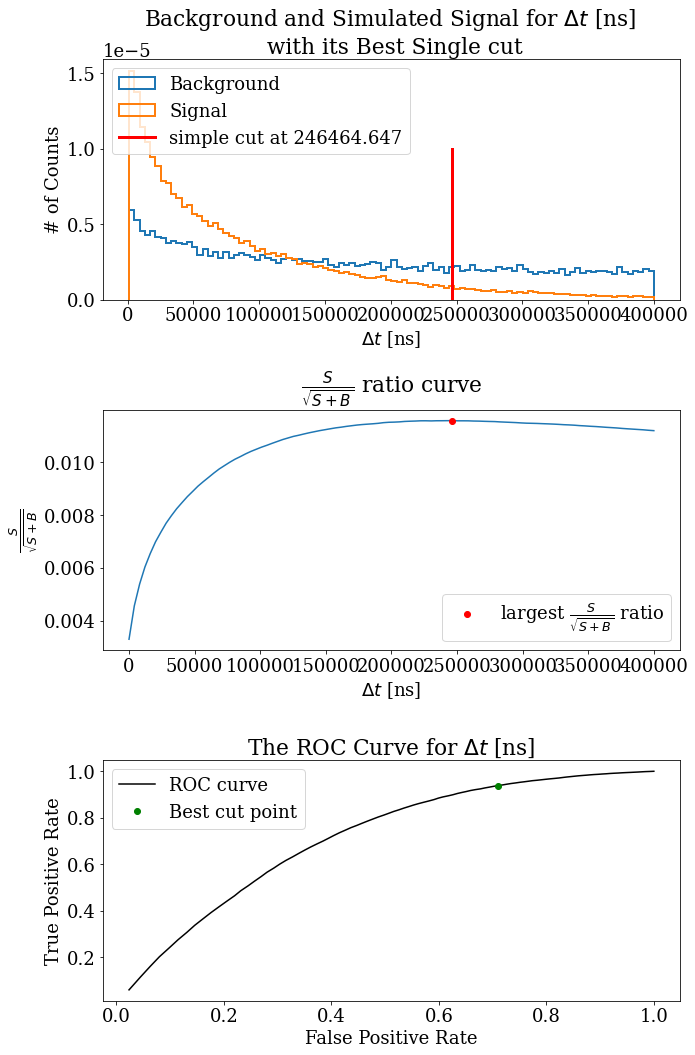

In [12]:
bins_t = 100 # delta t not discrete
a = 0
range_t = range(0,100)# delta t range
xrange_t = np.linspace(0.001,400000,100)# x range of delta t
y_t = np.linspace(0,1e-5,10)# y range of scaled events
HandBased(bins_t,a,range_t,xrange_t,y_t)

### <a id="xy"></a>[$\Delta xy$](#content)

The value of largest ratio is 1.070. 
The value of the corresponding $\Delta xy$ [cubes] is 2.667.
The true positive rate of the model is 96.50%.
The false positive rate of the model is 61.30%.


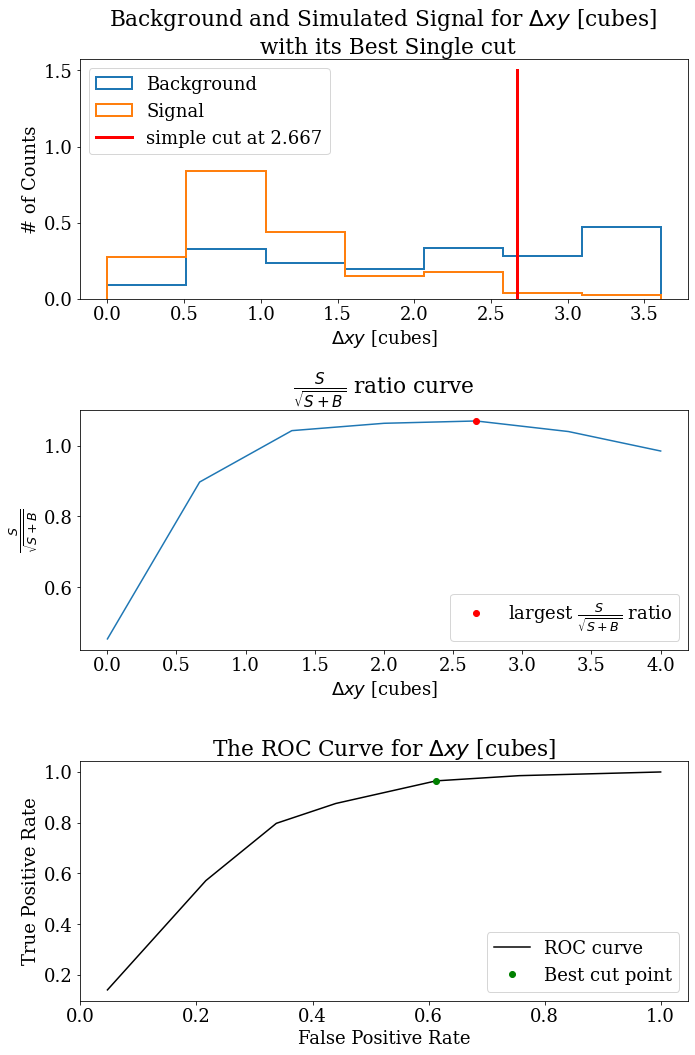

In [13]:
bins_t = 7# bin size should be chosen wisely as it is discrete data set
a = 1
range_t = range(0,7)
xrange_t = np.linspace(0.001,4,7)
y_t = np.linspace(0,1.5,10)
HandBased(bins_t,a,range_t,xrange_t,y_t)

### <a id="z"></a>[$\Delta z$](#content)

The value of largest ratio is 0.791. 
The value of the corresponding $\Delta z$ [cubes] is 3.572.
The true positive rate of the model is 98.46%.
The false positive rate of the model is 89.94%.


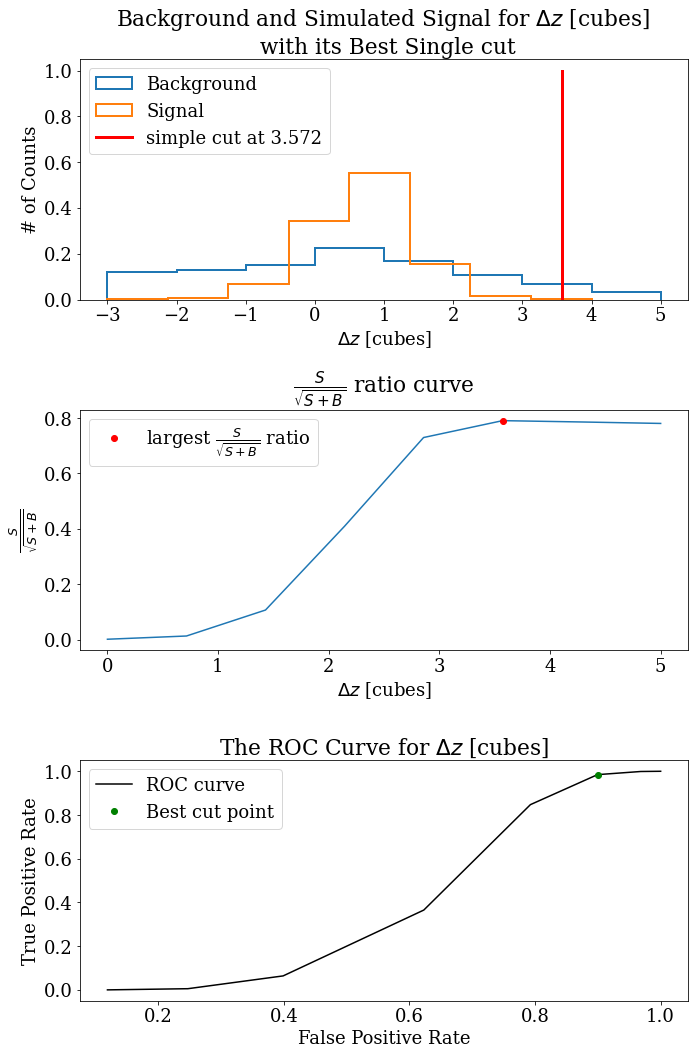

In [14]:
bins_t = 8# discrete
a = 2
range_t = range(0,8)
xrange_t = np.linspace(0.001,5,8)
y_t = np.linspace(0,1,10)
HandBased(bins_t,a,range_t,xrange_t,y_t)

### <a id="r"></a>[$\Delta r$](#content)

The value of largest ratio is 1.003. 
The value of the corresponding $\Delta r$ [cubes] is 1.876.
The true positive rate of the model is 85.10%.
The false positive rate of the model is 42.02%.


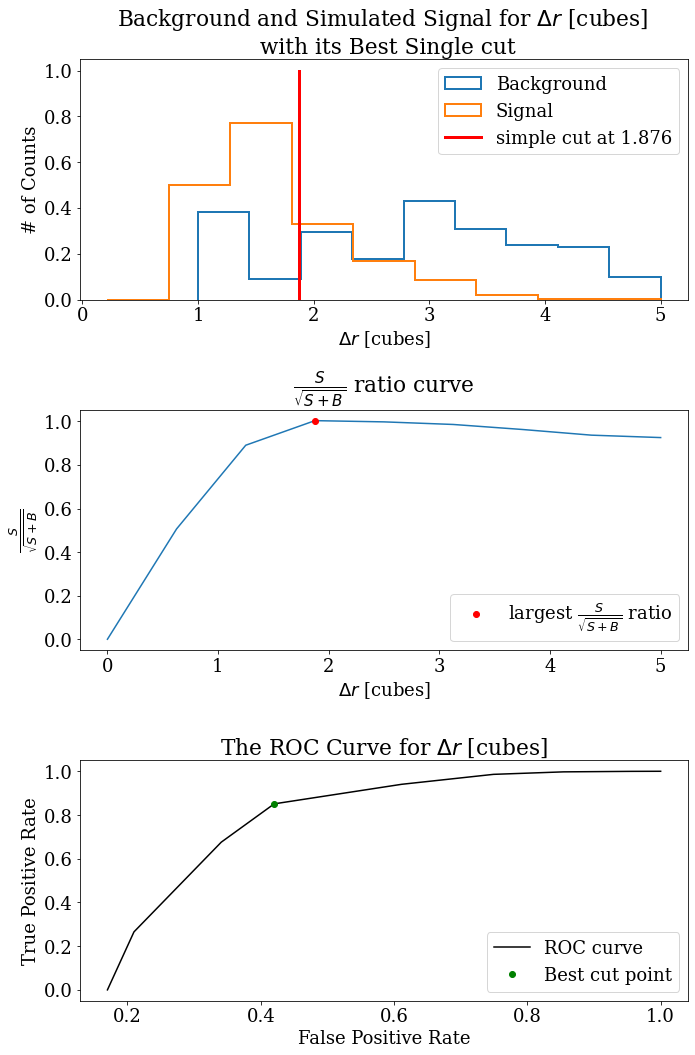

In [15]:
bins_t = 9# discrete
a = 3
range_t = range(0,9)
xrange_t = np.linspace(0.001,5,9)
y_t = np.linspace(0,1,10)
HandBased(bins_t,a,range_t,xrange_t,y_t)

### <a id="v"></a>[Volume](#content)

The value of largest ratio is 0.816. 
The value of the corresponding Volume [cubes] is 4.000.
The true positive rate of the model is 100.00%.
The false positive rate of the model is 100.00%.


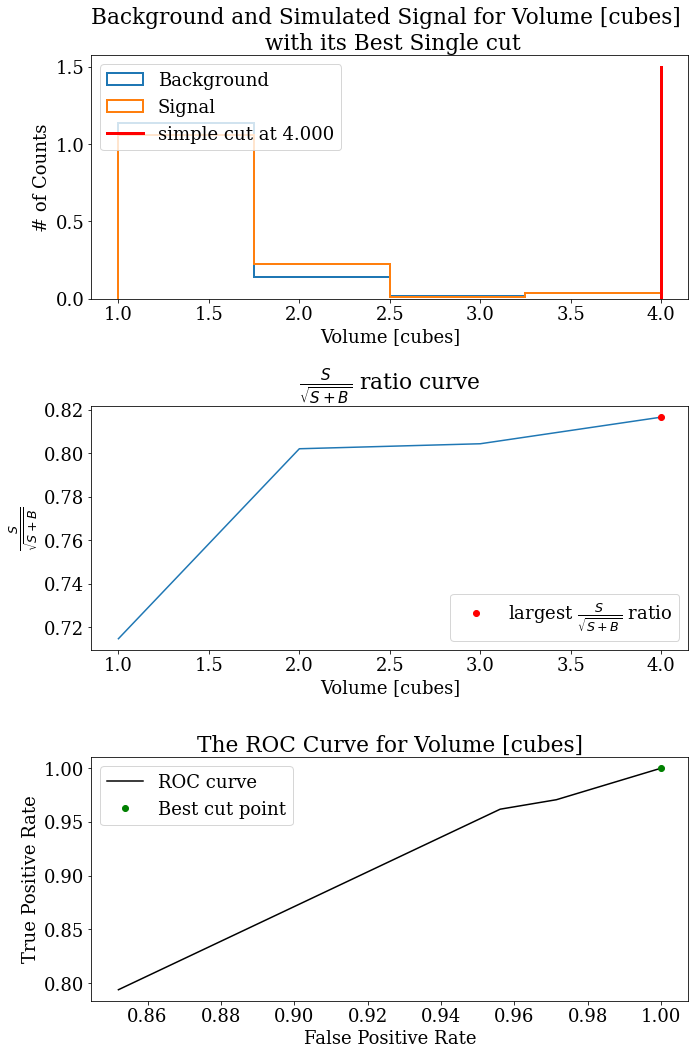

In [16]:
bins_t = 4# discrete
a = 4
range_t = range(0,4)
xrange_t = np.linspace(1,4,4)
y_t = np.linspace(0,1.5,10)
HandBased(bins_t,a,range_t,xrange_t,y_t)

In [17]:
def HandBased_E(bins,a,ranges,xranges,y):
    """
    This function is used to do a handbased analysis on the signal and background. 
    It helps users to get a simple cut for Prompt Energy to classify signal and background.
    This seperate function is defined due to its special feature of signal.
    Input:
        bins: bin size.
        a: the index of each variable.
        ranges: ranges for different bin size
        xranegs: x axis ranges for each variables in metric ratio plot
        y: y axis ranges for each variables in metric ratio plot
    Output:
        A plot of Background and Simulated Signal for Prompt Energy with its Best Single cut.
        A plot of $\\frac{S}{\sqrt{S+B}}$ ratio curve.
        A plot of The ROC Curve for Prompt Energy.
    """
    plt.rcParams['figure.figsize'] = [10, 15]# set graph size
    # plot the Background and Simulated Signal for each variable and grab data from the histogram.
    plt.subplot(3,1,1)
    n_b,bin_b,patches_b = plt.hist(df_offnon[df_offnon.columns[a]], bins, label = 'Background',
    cumulative = False, histtype='step', lw = 2,density = True)
    n_ss,bin_ss,patches_ss = plt.hist(df_simu[df_offnon.columns[a]], bins, label = 'Signal',
    cumulative = False, histtype='step', lw = 2,density = True)
    plt.xlabel(df_offnon.columns[a])
    plt.ylabel('# of Counts')
    plt.title('Background and Simulated Signal for {0} \n with its Best Single cut'.format(df_offnon.columns[a]))
    plt.legend()
    
    # plot $\\frac{S}{\sqrt{S+B}}$ ratio curve
    plt.subplot(3,1,2)
    # total signal and background
    S = np.sum(n_ss)
    B = np.sum(n_b)
    # create empty arrays for cutted signal and background
    s = []
    b = []
    # put each cutted signal and background into list
    for i in ranges:
        s.append(np.sum(n_ss[0:i]))
        b.append(np.sum(n_b[0:i]))
    # the signal is on the right in this case rather than on the left as previous cases
    s = S-np.array(s)
    b = B-np.array(b)
    # calculate the metric ratio
    ratio = (s)/np.sqrt(s+b)
    plt.plot(xranges,ratio)# plot the ratio against variables and print out the important quantities
    plt.xlabel(df_offnon.columns[a])
    plt.ylabel('$\\frac{S}{\sqrt{S+B}}$')
    plt.title('$\\frac{S}{\sqrt{S+B}}$ ratio curve')
    for n in ranges:
        if ratio[n] == max(ratio):
            print('The value of largest ratio is {0:.3f}. \nThe value of the corresponding {1} is {2:.3f}.'.format(ratio[n],df_offnon.columns[a],xranges[n]))
            plt.plot(xranges[n],ratio[n],'ro',label = 'largest $\\frac{S}{\sqrt{S+B}}$ ratio')
            plt.legend()
    
    
    # plot ROC curves/ similar to the previous one
    plt.subplot(3,1,3)
    FPR = []
    TPR = []
    for i in ranges:
        FPR.append(np.sum(n_b[0:i])/B)
        TPR.append(np.sum(n_ss[0:i])/S)
        
    FPR = 1-np.array(FPR)
    TPR = 1-np.array(TPR)

    plt.plot(FPR,TPR,'k',label = 'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC Curve for {0}'.format(df_offnon.columns[a]))
    for n in ranges:
        if ratio[n] == max(ratio):
            plt.plot(FPR[n],TPR[n],'go',label = 'Best cut point')
            plt.legend()
            print('The true positive rate of the model is {0:.2f}%.'.format(100*TPR[n]))
            print('The false positive rate of the model is {0:.2f}%.'.format(100*FPR[n]))
            # plot the best cut in graph 1
            plt.subplot(3,1,1)
            cut = np.ones(10)*xranges[n]
            plt.plot(cut,y,'r',linewidth=3, label = 'simple cut at {0:.3f}'.format(xranges[n]))

    plt.legend()

### <a id="e"></a>[$E_{prompt}$](#content)

The value of largest ratio is 3.106. 
The value of the corresponding $E_{prompt}$[MeV] is 1.424.
The true positive rate of the model is 86.32%.
The false positive rate of the model is 45.89%.


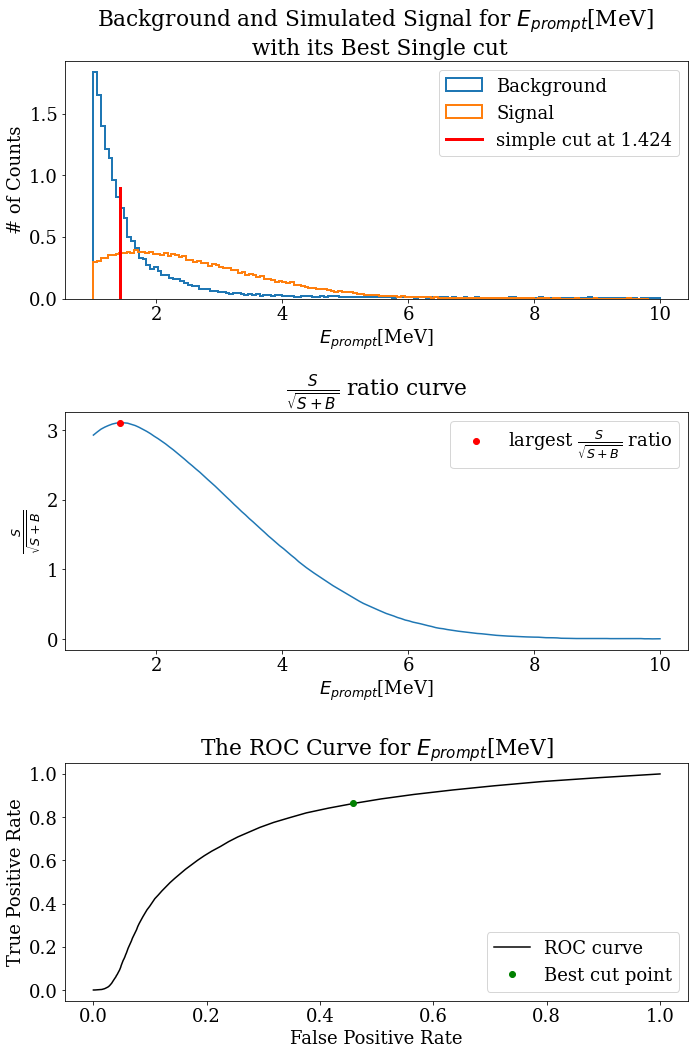

In [18]:
bins_t = 150
a = 5
range_t = range(0,150)
xrange_t = np.linspace(1.001,10,150)
y_t = np.linspace(0,0.9,10)
HandBased_E(bins_t,a,range_t,xrange_t,y_t)

<div class="alert alert-success"> <p>

<b>Discussion: </b> 

Fowllowing observations and conclusions can be made from the plots above:

- Most of the simple cuts present a good quality of classification as their TPR is excellent and FPR is not too significant. e.g. $\Delta r$ TPR:85.10%;FPR:42.02% and $E_{prompt}$ TPR:86.32%;FPR:45.89%. This means these two varibles may be a good choice for further analysis
- Volume has the worst performance in simple cut as the optimal simple cut cannot classify the signal and the baground based on this varible. This means it might not be a good choice in the following analysis.
- $\Delta t$ also has a very good performance of TPR:93.85% but its FPR is also not negligible(70.96%).
- All the variables except for Volumes can successfully optimize the $\frac{S}{\sqrt{S+B}}$ ratio and locate the best cuts
- Results of these simple cuts will be used as a baseline in the next stage.
</div>

## <a id="II"></a>[Part II](#content)

## Machine learning approach 

in this second part we are going to compare the simple cut analysis with the machine learning approach. 

- make a flow chart of how you are going to use each datasets to construct the training and test sets for signal and background. 
- Implement a couple of machine learning algorithms of your choice to build a discriminator (SVM, NN, etc...) that returns a probability. Comment on why you have chosen a specific model. You can find some interesting comparison here: 

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

<div class="alert alert-info"> <p>
    
<b>Method</b>
    
In this part, dataset with different ways of selection for variables. As it was concluded in Part I, $\Delta t$ and $E_{prompt}$ shows the best performance in all the tests. Therefore, the machine learning approach of analysis can be inductivel carried out from the these two variables, i.e. start from two dimentional classification. In this case, the classification and its decision boundaries can also be presented in a 2D plane and illustrate the performance of each classifier.
</div>

## <a id="2d"></a>[2D Classification](#content)

In [19]:
import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn import preprocessing

In [20]:
# adding target for classifiers
a = (np.ones(24930)).tolist()
df_offnon['target'] = a
dataset_b = pd.DataFrame()
dataset_b[['$\Delta t$ [ns]','$E_{prompt}$[MeV]','$\Delta r$ [cubes]','target']] = df_offnon[['$\Delta t$ [ns]','$E_{prompt}$[MeV]','$\Delta r$ [cubes]','target']]

In [21]:
# adding target for classifiers
b = (np.ones(79815)*0).tolist()
df_simu['target'] = b
dataset_s = pd.DataFrame()
dataset_s[['$\Delta t$ [ns]','$E_{prompt}$[MeV]','$\Delta r$ [cubes]','target']] = df_simu[['$\Delta t$ [ns]','$E_{prompt}$[MeV]','$\Delta r$ [cubes]','target']]

In [22]:
# stack two datasets
frames = [dataset_s,dataset_b]
dataset = pd.concat(frames)

Text(0, 0.5, '$E_{prompt}$[MeV]')

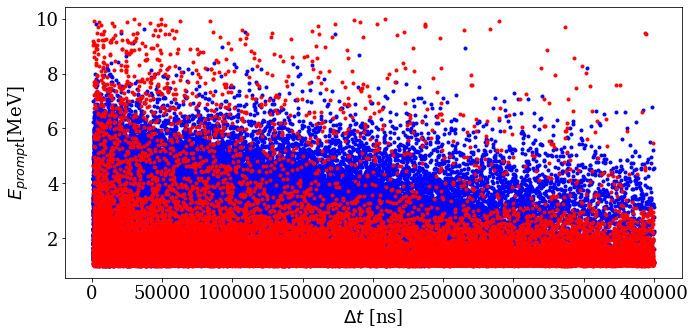

In [23]:
# plot the scattered points for the new dataset
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(dataset_s['$\Delta t$ [ns]'], dataset_s['$E_{prompt}$[MeV]'], c='b', marker='.')
plt.scatter(dataset_b['$\Delta t$ [ns]'], dataset_b['$E_{prompt}$[MeV]'], c='r', marker='.')
plt.xlabel('$\Delta t$ [ns]')
plt.ylabel('$E_{prompt}$[MeV]')

In [24]:
# defining X,y for 2d training and testing using stacking
dataset2d = np.stack((np.array(dataset['$\Delta t$ [ns]']),np.array(dataset['$E_{prompt}$[MeV]']),),axis = 1)
target = np.array(dataset['target'])

In [25]:
# split dataset into training set and testing set using train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset2d,target, test_size=0.5) #test selection

After defining the training and testing dataset, some function to help plotting the decision boundaries and ROC curve will be defined first.

In [26]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes, plot_training=True):
    """
    This function is defined to plot the decision boundaries of each classification
    Input:
        clf: classifier
        X: predictors
        y: targets
        axes: range of the plot [0,0,0,0]
    Output:
        decision boundaries of each classification
    """
    plt.rcParams['figure.figsize'] = [10, 5]
    # setting axes for the plot
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)# plotting contour
    
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    # plotting scattered data
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")

        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [27]:
from sklearn.metrics import accuracy_score
# define a function for plotting each classifier
def plotClassifier(clf):
    """
    This function is defiend to return a plot for different classifers.
    Input:
        clf: classifier
    Output:
        plot of decision boundaries of each classifer
    """
    clf.fit(X_train, y_train)
    pred=clf.predict(X_test)
    print('The accuracy score of this classifier is:',accuracy_score(y_test, pred))

    plot_decision_boundary(clf,X_train,y_train, axes=[0, 400000, 1, 10])
    plt.xlabel('$E_{prompt}$[MeV]')
    plt.ylabel('$\Delta t$ [ns]')
    plt.title('A Plot of Classifier Contour \nwith its Decision Boundaries',fontsize = 15)
    plt.show()

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    This function is defined as to plot the roc curve with given cofusion matrix.
    Input:
        fpr: false positive rate
        tpr: true positive rate
    Output:
        ROC curve
    """
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def ROCcurves(classifiers,meth):
    """
    This function is defined to plot a ROC curve with 90% of the performance
    Input:
        classifiers
        meth: ‘predict’, ‘predict_proba’, ‘predict_log_proba’, ‘decision_function’
    Output:
        ROC curve
    """
    y_train_pred = cross_val_predict(classifiers, X_train, y_train, cv=3, method=meth)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)


    recall_90_precision = tpr[np.argmax(fpr >= 0.90)]
    threshold_90_precision = thresholds[np.argmax(fpr >= 0.90)]

    print('The accuracy score of training set ROC curve is',roc_auc_score(y_train, y_train_pred))


    plt.figure(figsize=(8, 6))                                    
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
    plt.plot([fpr_90], [recall_90_precision], "ro")   
    plt.title('ROC curve')
    plt.show()

# SVM

/home/ql1821/solid/lib64/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/tmp/ipykernel_46248/1503836457.py:25: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)


The accuracy score of this classifier is: 0.7632749699272526


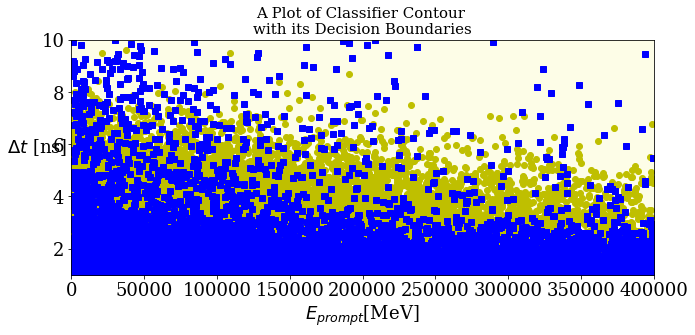

In [30]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC()
plotClassifier(svm_clf)

/home/ql1821/solid/lib64/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/ql1821/solid/lib64/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The accuracy score of training set ROC curve is 0.52212639057667


/home/ql1821/solid/lib64/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


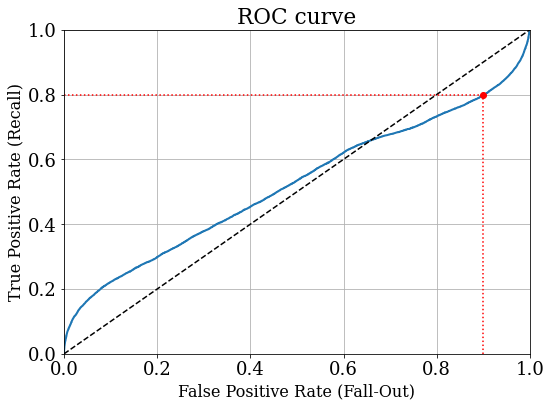

In [31]:
ROCcurves(svm_clf,"decision_function")

<div class="alert alert-success"> <p>
    
<b>Discussion</b>
    
For SVM classifier, the accuracy of it is 75% which is not too unreasonable, however, its performance is bad as its ROC curve is bending downwards compared to the random classifer. This means that SVM Linear is not a good choice for classification in this case. 
    
The accuracy score of the curve is also not ideal enough.
</div>

# SGD

The accuracy score of this classifier is: 0.7632749699272526


/tmp/ipykernel_46248/1503836457.py:25: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)


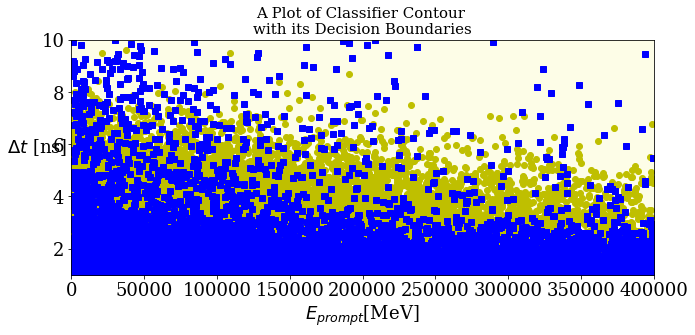

In [32]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
plotClassifier(sgd_clf)

The accuracy score of training set ROC curve is 0.3396895854243658


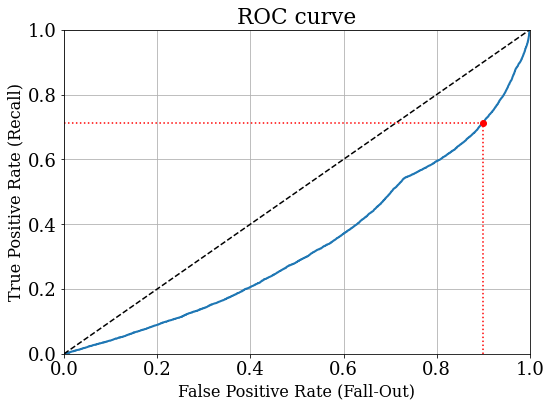

In [33]:
ROCcurves(sgd_clf,"decision_function")

<div class="alert alert-success"> <p>
    
<b>Discussion</b>
    
For SGD classifier, the accuracy score is way smaller than favoured, its performance is good at the beginning and become worse after some point. Overall, when the false positive rate is 90% the true positive rate is 80%. It may also be a bad choice in this case.
    
However, compared with the ROC curve for SVM classifier, it is better at initial stage.
</div>

# DT

The accuracy score of this classifier is: 0.8278502281710042


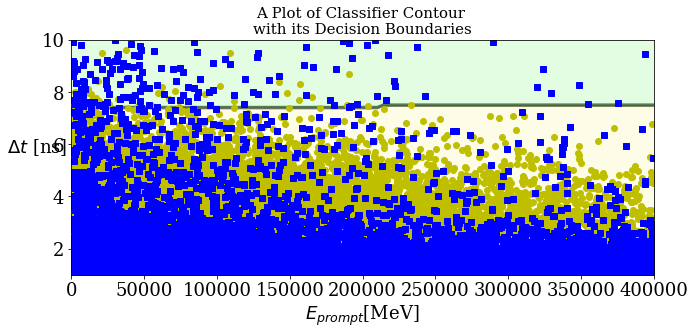

In [34]:
from sklearn.tree import DecisionTreeClassifier
dc_clf = DecisionTreeClassifier(max_depth=5, random_state =50)
plotClassifier(dc_clf)

The accuracy score of training set ROC curve is 0.6846520257538292


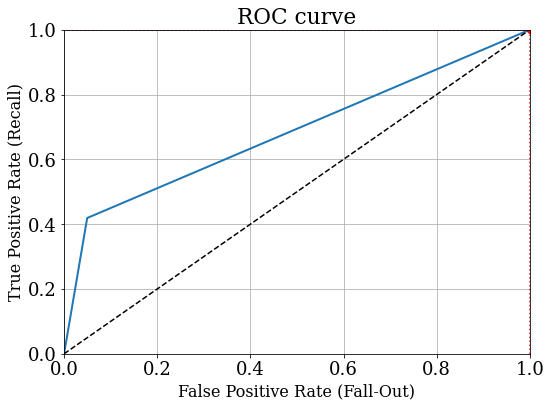

In [35]:
ROCcurves(dc_clf,"predict")

<div class="alert alert-success"> <p>
    
<b>Discussion</b>
    
The ROC curve failed to work with this classifier. However, the accuracy score of the classifier for classifying signal from background is 82% which is much better compare to the previous case.
</div>

## QDA

The accuracy score of this classifier is: 0.8036201859736888


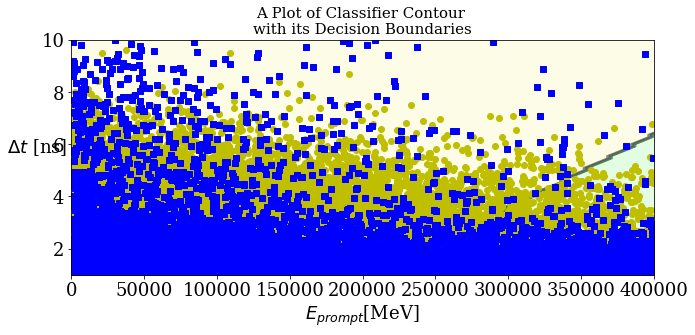

In [36]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qdaclf=QuadraticDiscriminantAnalysis() # this is stop a warning that doesn't apply to us anyway - try removing
plotClassifier(qdaclf)

The accuracy score of training set ROC curve is 0.7812435746817464


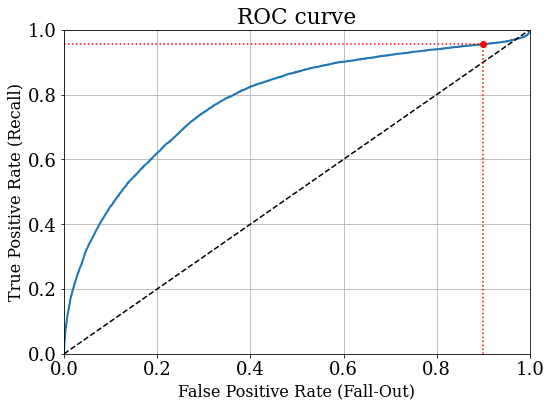

In [37]:
ROCcurves(qdaclf,"decision_function")

<div class="alert alert-success"> <p>
    
<b>Discussion</b>
    
The accuracy score for QDA classifier is 80.2% which is in the range of acceptance. and the ROC curve also presents a good performance as it is bending upwards compared to the random classifer. 
    
Therefore, QDA is the best classifier for two dimentional classification.
</div>

## <a id="3d"></a>[3D Classification](#content)

<div class="alert alert-danger"> <p>
    
<b>N.B.</b>
    
The process of three-dimentional classification is similar to the one used in 2D. The following cells took too long to run for visualization so they are commented for optimizing the quality of this notebook. Code in this part is still functional. Comment out all the cells if needed.

</div>

In [38]:
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [39]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(dataset_s['$\Delta t$ [ns]'], dataset_s['$\Delta r$ [cubes]'], dataset_s['$E_{prompt}$[MeV]'], c='r', marker='.')
# ax.scatter(dataset_b['$\Delta t$ [ns]'], dataset_b['$\Delta r$ [cubes]'], dataset_b['$E_{prompt}$[MeV]'], c='g', marker='.')

In [40]:
dataset3d = np.stack((np.array(dataset['$\Delta t$ [ns]']),np.array(dataset['$E_{prompt}$[MeV]']),np.array(dataset['$\Delta r$ [cubes]'])),axis = 1)

In [41]:
# import plotly
# import plotly.graph_objs as go

# #Then we split the dataset into the predictors set X (temperature, CO2 and HumidityRatio) and the independant variable y to predict (Occupancy) :
# X = dataset3d
# y = target


# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# #And we scale the values of the temperature, CO2 and humidity variables :

# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)


# # training_y_encoded = lab_enc.fit_transform(y_train)

# #A this step we are ready to fit the classifier to the training set data, which is done with the following code :


# classifier = XGBClassifier(use_label_encoder=False,eval_metric='error')
# classifier.fit(X_train, y_train)

# #Once ready, we can run the classifier on the training set and the test set in order to get the predictions.

# #predicting the results on the training set
# y_train_pred = classifier.predict(X_train)
# y_test_pred = classifier.predict(X_test)

# #In order to evaluate the quality of the classifier, we compute with the following code the two confusion matrix of the predictions made with the training and test set and according to them, the success ratio of the predictions :

# from sklearn.metrics import confusion_matrix
# cm_train = confusion_matrix(y_train, y_train_pred)
# cm_test = confusion_matrix(y_test, y_test_pred)

# def success_ratio(cm):
#     total = cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1]
#     return (cm[0][0] + cm[1][1]) / total

# print("Training set confusion matrix : \n"+str(cm_train))
# print("Success ratio on training set : "+str(success_ratio(cm=cm_train))+"%")
# print("Test set confusion matrix : \n"+str(cm_test))
# print("Success ratio on test set : "+str(success_ratio(cm=cm_test))+"%")

# #The console shows the two following confusion matrix and success ratio for the training and test sets :
# #Confusion Matrix for training and test set predictions in Python

# #Confusion Matrix for training and test set predictions in Python

# #Finally, we display in a 3D graph the test set observations (dots : black=occupancy and red=empty) and the model predictions (green transparent 3D shape = occupancy predictions) of the room occupancy according to temperature, CO2 and humidity levels with the following code :

# # displays in a 3D space the model as a 3D mesh and the test set observations as a 3D scatter plot
# def show3D(title, x_colname, y_colname, z_colname, c_colname, x_train, y_train, z_train, c_train, x_test, y_test, z_test, c_test, mesh_nb_pts, classifier):
#     n= int( mesh_nb_pts ** (1. / 3) ) #cubic root of mesh_nb_pts
#     min_x = min(x_train)
#     min_y = min(y_train)
#     min_z = min(z_train)
#     x_size = max(x_train) - min_x
#     y_size = max(y_train) - min_y
#     z_size = max(z_train) - min_z
#     x_step = x_size / n
#     y_step = y_size / n
#     z_step = z_size / n
#      #POSITIVE (1) PREDICTIONS AS A 3D MESH
#     i=0
#     x = np.empty([n*n*n])
#     y = np.empty([n*n*n])
#     z = np.empty([n*n*n])
#     for xi in range(0, n):
#         for yi in range(0, n):
#             for zi in range(0, n):
#                 x[i] = min_x + xi * x_step
#                 y[i] = min_y + yi * y_step
#                 z[i] = min_z + zi * z_step
#                 i = i + 1
#     print("Grid of size "+str(n)+"x"+str(n)+"x"+str(n)+" generated (nb vertices = "+str(n*n*n)+").")
#     #computing the predictions on the grid
#     datagrid = pd.DataFrame( {x_colname : x, y_colname: y, z_colname : z }) #the dataframe sort the columns lexicographically
#     datagrid = datagrid[[x_colname, y_colname, z_colname]] #fix the correct order of columns
#     p = classifier.predict(datagrid);
#     print("Predictions on the grid computed.")

#     #extracting the positive (1) records from the predictions
#     ss = sum(p)
#     xx = np.empty([ss])
#     yy = np.empty([ss])
#     zz = np.empty([ss])
#     pp = np.empty([ss])
#     j = 0
#     for i in range(0, len(p)-1):
#         if(p[i] == 1):
#             xx[j]=x[i]
#             yy[j]=y[i]
#             zz[j]=z[i]
#             pp[j]=p[i]
#             j = j + 1

#     print(str(ss)+" mesh coordinates extracted with positive predictions (=1).")

#     #building the mesh for the predictions
#     trace_preds = go.Mesh3d(
#     x=xx,y=yy,z=zz,
#     alphahull=5, opacity=0.2, color='rgb(0, 256, 0)',
#     name = 'Predictions'
#     )
#     print("Mesh generated.")

#     #OBSERVATIONS 3D POINTS
#     #number of positive (1) and negative (0) predictions
#     s_pts = len(c_test)
#     s_pts_0 = 0
#     s_pts_1 = 0
#     for i in range(0, s_pts):
#         if (c_test[i] == 0) :
#             s_pts_0 = s_pts_0 + 1
#         elif (c_test[i] == 1) :
#             s_pts_1 = s_pts_1 + 1
#         else :
#             print("ERROR : c_test["+str(i)+"] = "+str(c_test[i]))
#         break

#     #building two set of points (x,y,z coordinates) : one for the positive (1) predictions and another one for the (0) negative predictions
#     x_pts_0 = np.empty([s_pts_0])
#     y_pts_0 = np.empty([s_pts_0])
#     z_pts_0 = np.empty([s_pts_0])
#     x_pts_1 = np.empty([s_pts_1])
#     y_pts_1 = np.empty([s_pts_1])
#     z_pts_1 = np.empty([s_pts_1])
#     j = 0
#     k = 0
#     for i in range(0, s_pts):
#         if (c_test[i] == 0) :
#             x_pts_0[j] = x_test[i]
#             y_pts_0[j] = y_test[i]
#             z_pts_0[j] = z_test[i]
#             j = j + 1
#         elif (c_test[i] == 1) :
#             x_pts_1[k] = x_test[i]
#             y_pts_1[k] = y_test[i]
#             z_pts_1[k] = z_test[i]
#             k = k + 1
#         else :
#             print("ERROR : c_test["+str(i)+"] = "+str(c_test[i]))
#         break

#     trace_obs_0 = go.Scatter3d(
#     x=x_pts_0, y=y_pts_0, z=z_pts_0,
#     mode='markers',
#     marker=dict(size=2, line=dict(color='rgb(128, 0, 0)', width=0.5), color='rgb(128, 0, 0)', opacity=1),
#     name='[red] Observations of class 0'
#     )

#     trace_obs_1 = go.Scatter3d(
#     x=x_pts_1, y=y_pts_1,z=z_pts_1,
#     mode='markers',
#     marker=dict(size=2, line=dict( color='rgba(0, 0, 0)', width=0.5 ), color='rgb(0, 0, 0)', opacity=1),
#     name='[black] Observations of class 1'
#     )

#     layout = go.Layout(
#     title=title,
#     scene = dict(
#     xaxis=dict(title=x_colname),
#     yaxis=dict(title=y_colname),
#     zaxis=dict(title=z_colname)
#     )
#     )

#     fig = go.Figure(data=[trace_obs_0, trace_obs_1, trace_preds], layout=layout)
#     plotly.offline.plot(fig)

# show3D(title="3D Classification of Signal and background",
# x_colname = 'Temperature', y_colname = 'CO2', z_colname = 'HumidityRatio', c_colname = 'Occupancy',
# x_train = X_train[:,0], y_train=X_train[:,1], z_train=X_train[:,2], c_train=y_train,
# x_test = X_test[:,0], y_test = X_test[:,1], z_test = X_test[:,2], c_test=y_test,
# mesh_nb_pts = 50**3,
# classifier = classifier)

## <a id="6d"></a>[6D Classification](#content)

<div class="alert alert-info"> <p>
    
<b>Method</b>

The analysis in 6D classification is still similar to the previous cases. The difference is that we can hardly visualize the classification with plots as it is over 3 dimentions. 

Therefore, the method in this part that can justify the goodness of a classification will be ROC curves. Confusion matrix with its success ratio are also calculated in this part for further comparison.
    
</div>

In [42]:
b = (np.ones(79815)*0).tolist()

df_simu['target'] = b
dataset_s6d = pd.DataFrame()
dataset_s6d[['$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
        '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]',
           'target']] = df_simu[['$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
                    '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]','target']]

In [43]:
a = (np.ones(24930)).tolist()

df_offnon = df_offnon.loc[df_offnon['$\Delta r$ [cubes]'] > 0]
df_offnon = df_offnon.loc[df_offnon['$\Delta t$ [ns]'] > 0]
df_offnon['target'] = a
dataset_b6d = pd.DataFrame()
dataset_b6d[['$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
        '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]',
           'target']] = df_offnon[['$\Delta t$ [ns]','$\Delta xy$ [cubes]','$\Delta z$ [cubes]',
                    '$\Delta r$ [cubes]','Volume [cubes]','$E_{prompt}$[MeV]','target']]

In [44]:
frames6d = [dataset_s6d,dataset_b6d]
dataset6d = pd.concat(frames6d)

In [45]:
dataset_6d =  np.stack((np.array(dataset6d['$\Delta t$ [ns]']),np.array(dataset6d['$\Delta xy$ [cubes]']),np.array(dataset6d['$\Delta z$ [cubes]']),np.array(dataset6d['$\Delta r$ [cubes]']),np.array(dataset6d['Volume [cubes]']),np.array(dataset6d['$E_{prompt}$[MeV]']),np.array(dataset['$\Delta r$ [cubes]'])),axis = 1)

In [46]:
#Then we split the dataset into the predictors set X (temperature, CO2 and HumidityRatio) and the independant variable y to predict (Occupancy) :
def clf6D(clf):
    """
    This function is defiend to return a plot for different classifers.
    Input:
        clf: classifier
    Output:
        plot of decision boundaries of for 6d classifiers
    """
    X = dataset_6d
    y = target


    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


    #And we scale the values of the temperature, CO2 and humidity variables :

    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    #A this step we are ready to fit the classifier to the training set data, which is done with the following code :


    classifier = clf
    classifier.fit(X_train, y_train)

    #Once ready, we can run the classifier on the training set and the test set in order to get the predictions.

    #predicting the results on the training set
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    #In order to evaluate the quality of the classifier, we compute with the following code the two confusion matrix of the predictions made with the training and test set and according to them, the success ratio of the predictions :

    from sklearn.metrics import confusion_matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    def success_ratio(cm):
        total = cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1]
        return (cm[0][0] + cm[1][1]) / total

    print("Training set confusion matrix : \n"+str(cm_train))
    print("Success ratio on training set : "+str(success_ratio(cm=cm_train)))
    print("Test set confusion matrix : \n"+str(cm_test))
    print("Success ratio on test set : "+str(success_ratio(cm=cm_test)))

In [47]:
def ROCcurves6D(classifiers,meth):
    """
    This function is defined to plot a ROC curve with random classifier curve
    Input:
        classifiers
        meth: ‘predict’, ‘predict_proba’, ‘predict_log_proba’, ‘decision_function’
    Output:
        ROC curve for 6d classifiers
    """
    X = dataset_6d
    y = target


    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    y_train_pred = cross_val_predict(classifiers, X_train, y_train, cv=3, method=meth)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)


    recall_90_precision = tpr[np.argmax(fpr >= 0.90)]
    threshold_90_precision = thresholds[np.argmax(fpr >= 0.90)]

    print('The accuracy score of the ROC curve is:',roc_auc_score(y_train, y_train_pred))


    plt.figure(figsize=(8, 6))                                    # Not shown
    plot_roc_curve(fpr, tpr)
    fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
    plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
    plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
    plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
    #save_fig("roc_curve_plot")                                    # Not shown
    plt.show()

In [48]:
clf6D(SGDClassifier())

Training set confusion matrix : 
[[61643  2162]
 [ 7960 12031]]
Success ratio on training set : 0.879206644708578
Test set confusion matrix : 
[[15487   523]
 [ 2013  2926]]
Success ratio on test set : 0.8789441023437873


The accuracy score of the ROC curve is: 0.45855387921978885


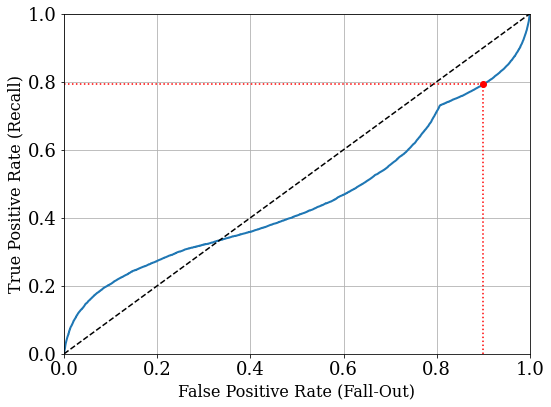

In [49]:
ROCcurves6D(sgd_clf,"decision_function")

In [50]:
clf6D(DecisionTreeClassifier(max_depth=5, random_state =50))

Training set confusion matrix : 
[[61160  2645]
 [ 6938 13053]]
Success ratio on training set : 0.8856389326459497
Test set confusion matrix : 
[[15346   664]
 [ 1749  3190]]
Success ratio on test set : 0.8848155043200153


The accuracy score of the ROC curve is: 0.7929987289829361


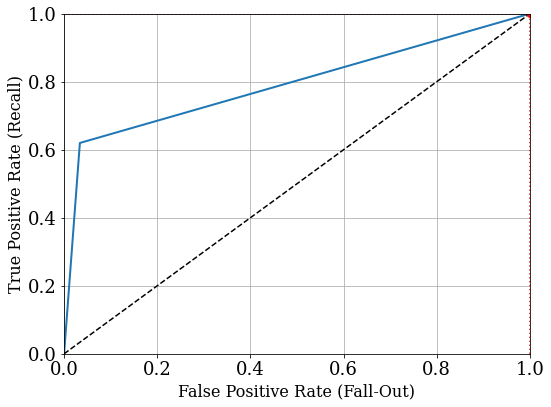

In [51]:
ROCcurves6D(dc_clf,"predict")

In [52]:
clf6D(qdaclf)

Training set confusion matrix : 
[[60609  3196]
 [ 8672 11319]]
Success ratio on training set : 0.8583703279392811
Test set confusion matrix : 
[[15240   770]
 [ 2182  2757]]
Success ratio on test set : 0.8590863525705285


/home/ql1821/solid/lib64/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


/home/ql1821/solid/lib64/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ql1821/solid/lib64/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ql1821/solid/lib64/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


The accuracy score of the ROC curve is: 0.7378490354355879


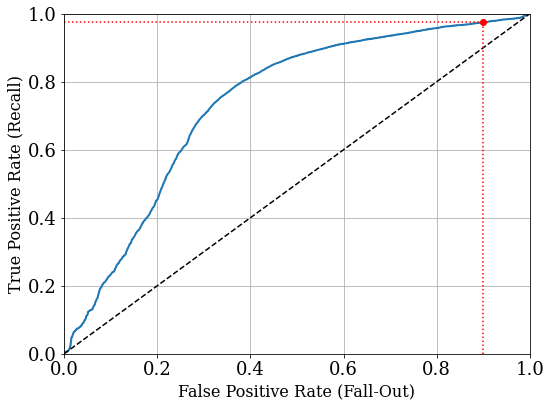

In [53]:
ROCcurves6D(qdaclf,"decision_function")

<div class="alert alert-success"> <p>
    
<b>Discussion</b>
    
- As it is shown above, these classifiers show similar behaviours compare to the case in 2D.
    - SGD classifier has a better success ratio while it still performs badly in ROC curves(bending upwards first and downwards after some points). Its accuracy of ROC curve is also not ideal.
    - ROC curve still fail to work for Decision Tree classifier but has a better success ratio compared to the 2d case.
    - QDA still performs the best in 6d case.
- Here QDA classifier shows a warning of collinear variables, this might be caused by correlations between some of the variables.
</div>

# <a id="conclusion"></a>[Conclusion and Summary](#content)

<div class="alert alert-success"> <p>
    
- In the first part, the performance of simple cut is used to compared with the machine learning results as a baseline. However, most of the classifiers failed in different ways and only QDA classifier works with similar performance as the simple cut.
- ROC curves and the $\frac{S}{\sqrt{S+B}}$ ratio curve are both useful in justifying the goodness of a classification.
- ROC curve is not always work for all classifier.
- Visualization is not neccessary in all case, especially for classification with more than three variables.
- In this project, most of the time was invest into the first part with data processing. It revealed the situation we may encountered in the future. In this case, we should not be obssessed with the meaningless data and keep focusing on improving the methods and the collection of datasets.
    
<b>Improvements</b>
    
Due to the time limitation, some of the analysis is not carried out in this project. Further work should be done with the multi-variable case. for instance, the $\frac{S}{\sqrt{S+B}}$ ratio should be optimize to find the best performance of each classifier. The background signal in other dataset can also be use to make comparisons with the reactor off non-shifted scenario.
</div>

/home/ql1821/CNN/lib/python3.9/site-packages/IPython/nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "
/home/ql1821/CNN/lib/python3.9/site-packages/nbformat/current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.


NameError: name 'filepath' is not defined